Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, InputLayer, MaxPooling2D, Rescaling, RandomFlip, RandomRotation, RandomContrast, RandomBrightness
from tensorflow.keras.regularizers import l2

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%ls -altr /content/gdrive/MyDrive/'Skin cancer ISIC The International Skin Imaging Collaboration'/

total 8
drwx------ 2 root root 4096 Aug  3 13:39 Train/
drwx------ 2 root root 4096 Aug  3 13:39 Test/


In [5]:
path_to_train_directory = "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
path_to_test_directory = "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test"

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images

data_dir_train = pathlib.Path(path_to_train_directory)
data_dir_test = pathlib.Path(path_to_test_directory)

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("train images count = {}".format(image_count_train))
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("test images count = {}".format(image_count_test))

train images count = 2239
test images count = 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.
keras.preprocessing is deprecated now, using keras.utils instead.

In [8]:
from tensorflow.keras.utils import load_img

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

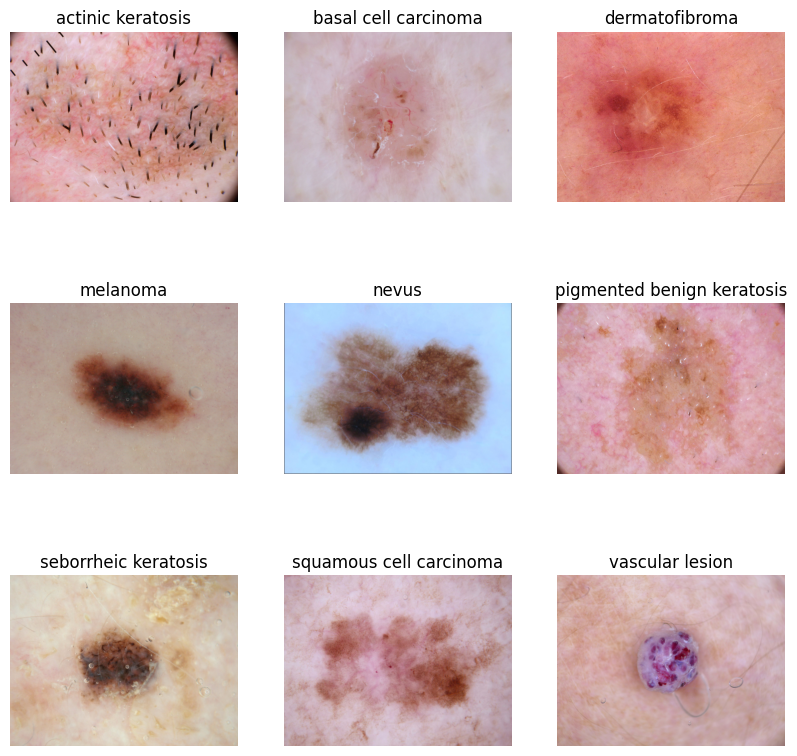

In [13]:
plt.figure(figsize=(10,10))

for lesion_type in range(class_number):
    class_path = glob(os.path.join(data_dir_train, class_names[lesion_type], '*'))
    lesion_imgs = list(class_path)
    img = PIL.Image.open(str(lesion_imgs[0]))
    ax = plt.subplot(3,3, lesion_type+1)
    plt.imshow(img)
    plt.title(class_names[lesion_type])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
# Note the first layer (Rescaling(1./255) rescales the RGB channel values.

num_classes = 9

model = tf.keras.Sequential([
  InputLayer(input_shape=(img_height, img_width, 3)),
  Rescaling(1./255),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 536s 2s/step - loss: 1.9164 - accuracy: 0.2919 - val_loss: 1.7557 - val_accuracy: 0.3848
Epoch 2/20
56/56 [==============================] - 2s 28ms/step - loss: 1.6698 - accuracy: 0.4023 - val_loss: 1.5587 - val_accuracy: 0.4251
Epoch 3/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4569 - accuracy: 0.5011 - val_loss: 1.4118 - val_accuracy: 0.5324
Epoch 4/20
56/56 [==============================] - 2s 28ms/step - loss: 1.3805 - accuracy: 0.5151 - val_loss: 1.4477 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.2897 - accuracy: 0.5547 - val_loss: 1.3417 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 2s 28ms/step - loss: 1.2204 - accuracy: 0.5792 - val_loss: 1.3960 - val_accuracy: 0.5414
Epoch 7/20
56/56 [==============================] - 2s 27ms/step - loss: 1.1541 - accuracy: 0.5988 - val_loss: 1.3864 - val_accuracy: 0.5123
Epoch 8/20
56

### Visualizing training results

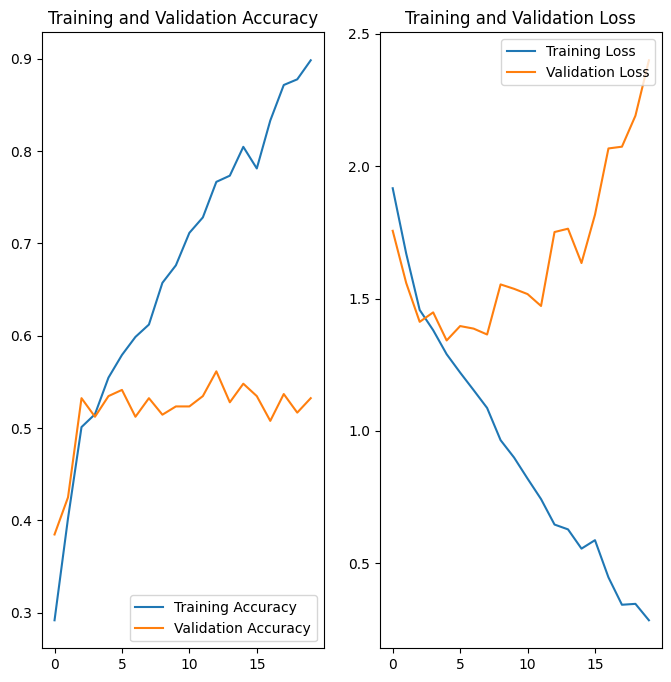

In [19]:
def show_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

show_history(history)

### Observations

- The training accuracy keeps increasing, whereas validation accuracy is quite poor, having difference of almost 40%.
- This clearly means the model is overfitting the data.
- Also, it is observed that with the training loss decreasing, the validation loss is increasing.

In [20]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomContrast(0.2),
    RandomBrightness(0.2)
])

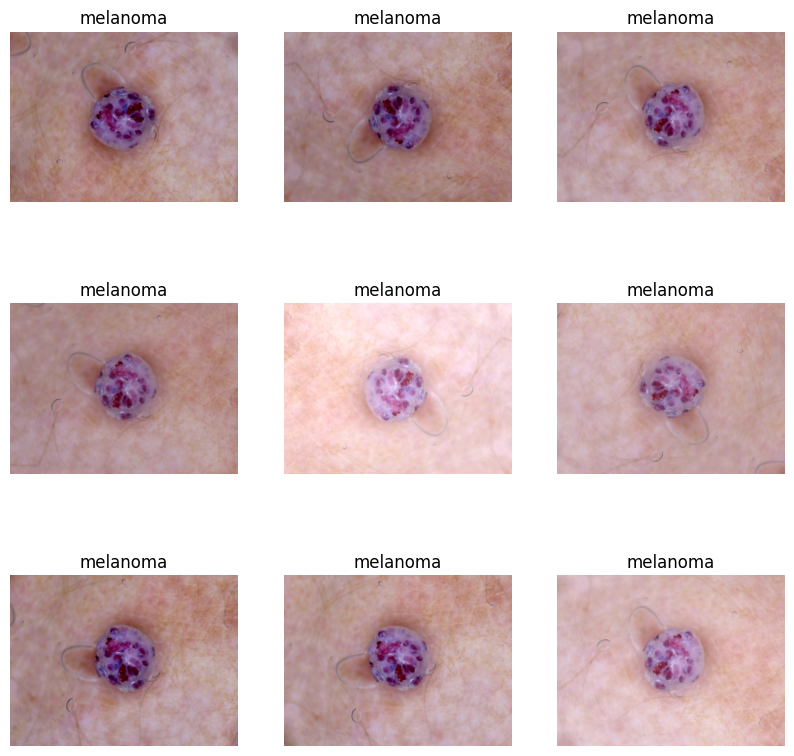

In [21]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_image = data_augmentation(img)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.title(class_names[labels[1]])
    plt.axis("off")


### Model Creation with Augmentation and Dropout layers

In [22]:
# Adding data augmentation to the model
model_with_aug = tf.keras.Sequential([
  InputLayer(input_shape=(img_height, img_width, 3)),
  data_augmentation,
  Rescaling(1./255),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

### Model Compilation

In [23]:
model_with_aug.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model Training

In [24]:
epochs = 20
history = model_with_aug.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 38ms/step - loss: 1.8581 - accuracy: 0.3242 - val_loss: 1.5811 - val_accuracy: 0.4497
Epoch 2/20
56/56 [==============================] - 2s 32ms/step - loss: 1.6060 - accuracy: 0.4224 - val_loss: 1.5433 - val_accuracy: 0.4698
Epoch 3/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5395 - accuracy: 0.4515 - val_loss: 1.4190 - val_accuracy: 0.5123
Epoch 4/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5087 - accuracy: 0.4665 - val_loss: 1.4479 - val_accuracy: 0.4989
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.4196 - accuracy: 0.4888 - val_loss: 1.3744 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.4085 - accuracy: 0.5073 - val_loss: 1.4085 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 2s 31ms/step - loss: 1.3838 - accuracy: 0.5151 - val_loss: 1.5819 - val_accuracy: 0.4899
Epoch 8/20
56

### Visualization training results

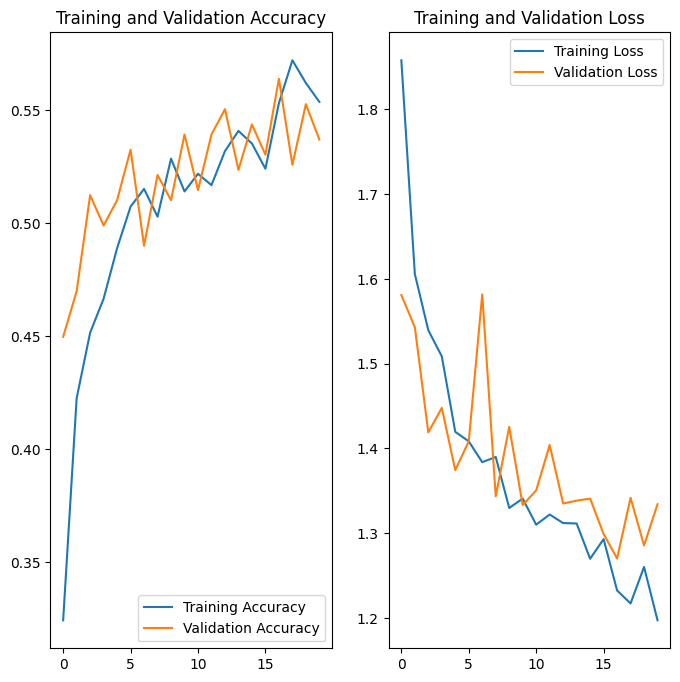

In [25]:
show_history(history)

Performance on the modified model

- The gap between training and validation accuracies has reduced because of data augmentation layer.
- This means the overfitting has been reduced.
- The training accuracy has come down to 0.55 from 0.89.
- Increasing the number of epoch might increase the accuracies as overfitting is less.

In [26]:
# Adding dropout of 0.25 to the model
model_with_aug_drop = tf.keras.Sequential([
  InputLayer(input_shape=(img_height, img_width, 3)),
  data_augmentation,
  Rescaling(1./255),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.25),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

# Model compilation
model_with_aug_drop.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model Training
epochs = 20
history = model_with_aug_drop.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 56ms/step - loss: 2.1587 - accuracy: 0.2188 - val_loss: 1.9248 - val_accuracy: 0.3199
Epoch 2/20
56/56 [==============================] - 3s 49ms/step - loss: 1.8527 - accuracy: 0.3304 - val_loss: 1.6520 - val_accuracy: 0.4139
Epoch 3/20
56/56 [==============================] - 3s 49ms/step - loss: 1.6513 - accuracy: 0.4152 - val_loss: 1.5187 - val_accuracy: 0.4877
Epoch 4/20
56/56 [==============================] - 3s 49ms/step - loss: 1.5610 - accuracy: 0.4492 - val_loss: 1.4850 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 3s 55ms/step - loss: 1.5214 - accuracy: 0.4520 - val_loss: 1.4667 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 3s 49ms/step - loss: 1.5098 - accuracy: 0.4570 - val_loss: 1.4701 - val_accuracy: 0.4720
Epoch 7/20
56/56 [==============================] - 3s 49ms/step - loss: 1.4442 - accuracy: 0.4732 - val_loss: 1.4449 - val_accuracy: 0.5011
Epoch 8/20
56

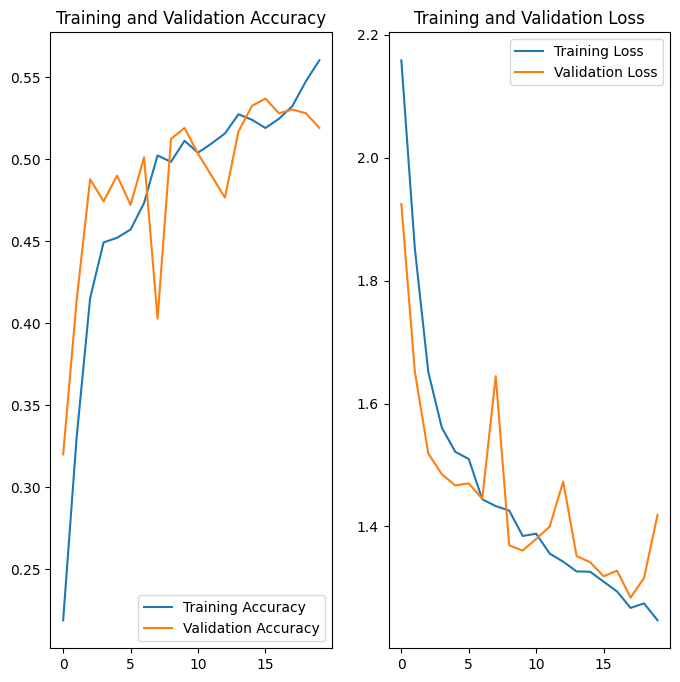

In [27]:
# Check accuracies and losses
show_history(history)

#### Observations:
- Not much of a difference between the model with only data augmentation layer and the model with both augmentation layer and dropouts.
- Since both of these are used for reducing overfitting, we can see the gap between training and validation accuracies has reduced compared to the first model.

### Distribution of classes in the training dataset

In [28]:
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

# adjustments
count = labels.value_counts().sort_index()
count.index = class_names
print(count)

actinic keratosis              92
basal cell carcinoma          309
dermatofibroma                 77
melanoma                      352
nevus                         277
pigmented benign keratosis    370
seborrheic keratosis           58
squamous cell carcinoma       142
vascular lesion               115
dtype: int64


#### Observations on class distribution:
- **Which class has the least number of samples?**
  
  Seborrheic keratosis has the least number of samples at 58

- **Which classes dominate the data in terms proportionate number of samples?**

 The classes with the most samples are:
 - pigmented benign keratosis - 370
 - melanoma - 352
 - basal cell carcinoma - 309
 - nevus - 277

 Clearly the classes "pigmented benign keratosis" and "melanoma" dominate the data.


### Handling class imbalance

In [29]:
!pip install Augmentor

In [30]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) + '/' + str(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8916ACBB80>: 100%|██████████| 500/500 [00:20<00:00, 23.83 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E89162F3070>: 100%|██████████| 500/500 [00:23<00:00, 21.05 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8916400070>: 100%|██████████| 500/500 [00:22<00:00, 22.44 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x7E8916ACAAA0>: 100%|██████████| 500/500 [01:27<00:00,  5.72 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7E8916ACBB80>: 100%|██████████| 500/500 [01:29<00:00,  5.58 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E89162E0E20>: 100%|██████████| 500/500 [00:17<00:00, 28.32 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E8955BE6CB0>: 100%|██████████| 500/500 [00:38<00:00, 12.89 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8916ACAAA0>: 100%|██████████| 500/500 [00:16<00:00, 30.75 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E89162E3040>: 100%|██████████| 500/500 [00:19<00:00, 25.68 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Dataset Creation, Model Creation and Training

In [32]:
batch_size = 32
img_height = 180
img_width = 180

### Training dataset creation

In [33]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Lets see the distribution of augmented data after adding new images to the original training data.

actinic keratosis             493
basal cell carcinoma          721
dermatofibroma                455
melanoma                      755
nevus                         677
pigmented benign keratosis    773
seborrheic keratosis          456
squamous cell carcinoma       569
vascular lesion               493
dtype: int64


<Axes: >

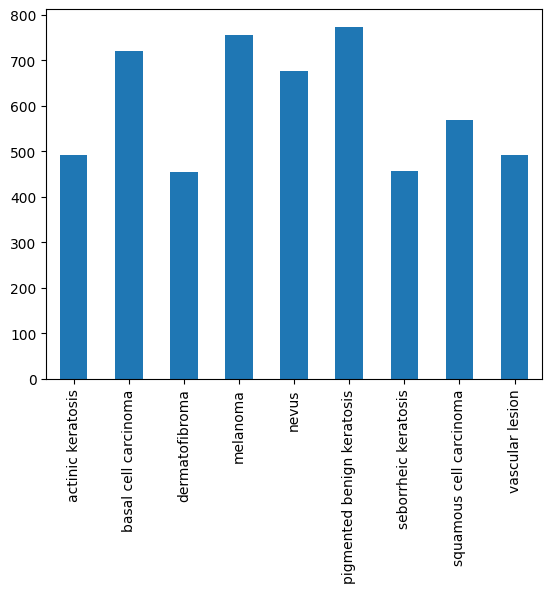

In [34]:
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

# adjustments
count = labels.value_counts().sort_index()
count.index = class_names
print(count)
count.plot(kind="bar")

#### Observation:
- None of the categories can now be said to be sparse since we added 500 images to the data set through augmentation.

### Validation dataset creation

In [35]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Model Creation (with and without normalization)

In [36]:
# Rebuilding the model without data augmentation layer and no normalization
model_with_dropout = tf.keras.Sequential([
  InputLayer(input_shape=(img_height, img_width, 3)),
  Rescaling(1./255),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.25),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

# Compiling the model
model_with_dropout.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Training the model for 20 epochs
epochs = 20
history = model_with_dropout.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 44s 239ms/step - loss: 1.9356 - accuracy: 0.2700 - val_loss: 1.5363 - val_accuracy: 0.4195
Epoch 2/20
169/169 [==============================] - 41s 235ms/step - loss: 1.4145 - accuracy: 0.4638 - val_loss: 1.2696 - val_accuracy: 0.5301
Epoch 3/20
169/169 [==============================] - 39s 226ms/step - loss: 1.1879 - accuracy: 0.5547 - val_loss: 1.1169 - val_accuracy: 0.5969
Epoch 4/20
169/169 [==============================] - 42s 241ms/step - loss: 0.9612 - accuracy: 0.6552 - val_loss: 1.0058 - val_accuracy: 0.6437
Epoch 5/20
169/169 [==============================] - 41s 239ms/step - loss: 0.7748 - accuracy: 0.7196 - val_loss: 0.9014 - val_accuracy: 0.6956
Epoch 6/20
169/169 [==============================] - 52s 300ms/step - loss: 0.6199 - accuracy: 0.7728 - val_loss: 0.8901 - val_accuracy: 0.7045
Epoch 7/20
169/169 [==============================] - 47s 268ms/step - loss: 0.4904 - accuracy: 0.8251 - val_loss: 0.7978 - val_ac

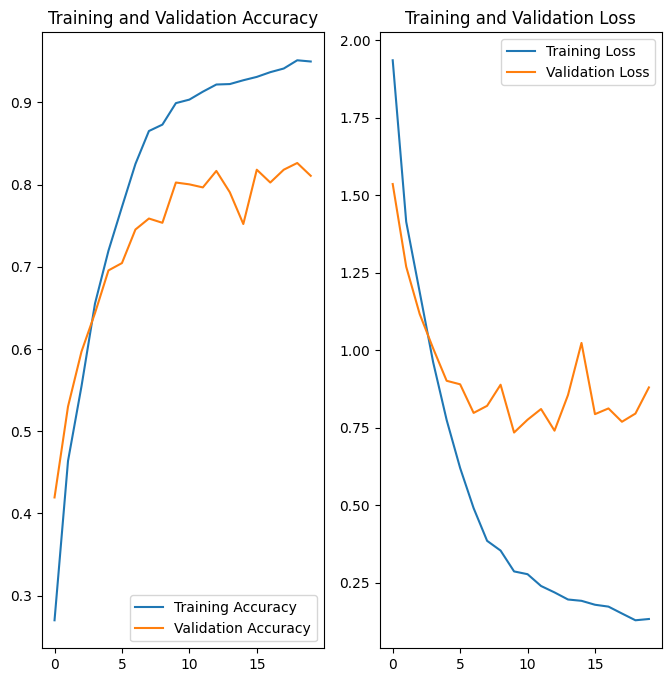

In [37]:
show_history(history)

#### Observations:
- Since we dropped data augmentation layer and augmented the dataset itself, the same model seems to be performing much better.
- The accuracies have improved drastically from the previous models.
- The gap between training and validation accuracies keeps increasing after 5 epochs, showing the presence of overfitting.
- The validation loss also keeps increasing with increasing epochs.

### Model with normalization layers

Epoch 1/20
169/169 [==============================] - 41s 214ms/step - loss: 2.5006 - accuracy: 0.3179 - val_loss: 2.2348 - val_accuracy: 0.0898
Epoch 2/20
169/169 [==============================] - 39s 226ms/step - loss: 1.2796 - accuracy: 0.5302 - val_loss: 2.2384 - val_accuracy: 0.1849
Epoch 3/20
169/169 [==============================] - 40s 229ms/step - loss: 1.0402 - accuracy: 0.6291 - val_loss: 1.3758 - val_accuracy: 0.4647
Epoch 4/20
169/169 [==============================] - 40s 228ms/step - loss: 0.8334 - accuracy: 0.7075 - val_loss: 1.8204 - val_accuracy: 0.4610
Epoch 5/20
169/169 [==============================] - 38s 219ms/step - loss: 0.6544 - accuracy: 0.7713 - val_loss: 0.9830 - val_accuracy: 0.6882
Epoch 6/20
169/169 [==============================] - 44s 254ms/step - loss: 0.5704 - accuracy: 0.8027 - val_loss: 1.0873 - val_accuracy: 0.6533
Epoch 7/20
169/169 [==============================] - 42s 242ms/step - loss: 0.4512 - accuracy: 0.8450 - val_loss: 2.3061 - val_ac

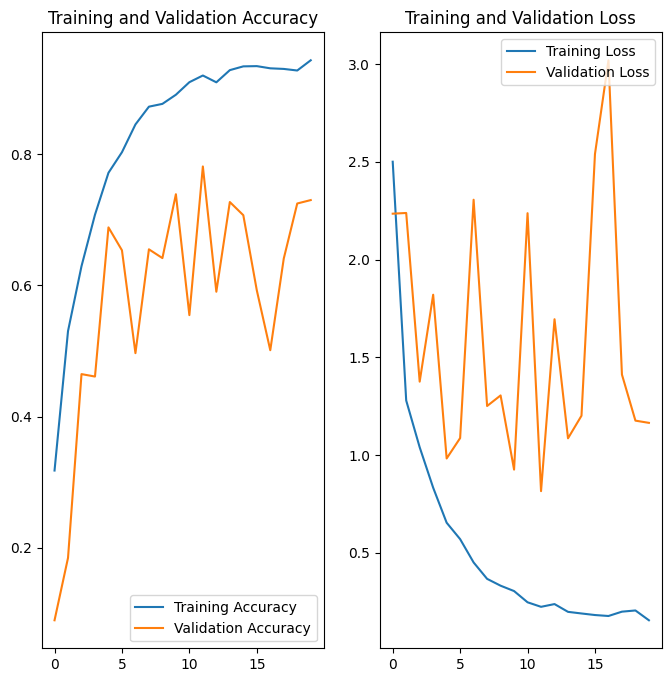

In [39]:
# Building a model with BatchNormalization
model_with_drop_norm = tf.keras.Sequential([
  InputLayer(input_shape=(img_height, img_width, 3)),
  Rescaling(1./255),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  BatchNormalization(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  BatchNormalization(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.25),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

# Model compilation
model_with_drop_norm.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Training the model for 20 epochs
epochs = 20
history = model_with_drop_norm.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

show_history(history)

#### Observations
- The model seems to have become unstable with large swings in accuracies and losses.
- The large gaps between training and validation accuracies mean model overfitting the data.

### Model Compilation

Epoch 1/20
169/169 [==============================] - 43s 231ms/step - loss: 2.0514 - accuracy: 0.2331 - val_loss: 1.6468 - val_accuracy: 0.3638
Epoch 2/20
169/169 [==============================] - 40s 232ms/step - loss: 1.6446 - accuracy: 0.3629 - val_loss: 1.4925 - val_accuracy: 0.4395
Epoch 3/20
169/169 [==============================] - 40s 229ms/step - loss: 1.5360 - accuracy: 0.4104 - val_loss: 1.4421 - val_accuracy: 0.4373
Epoch 4/20
169/169 [==============================] - 40s 229ms/step - loss: 1.4754 - accuracy: 0.4262 - val_loss: 1.6113 - val_accuracy: 0.4417
Epoch 5/20
169/169 [==============================] - 42s 245ms/step - loss: 1.4528 - accuracy: 0.4442 - val_loss: 1.3833 - val_accuracy: 0.4551
Epoch 6/20
169/169 [==============================] - 39s 226ms/step - loss: 1.4046 - accuracy: 0.4601 - val_loss: 1.3427 - val_accuracy: 0.4736
Epoch 7/20
169/169 [==============================] - 42s 241ms/step - loss: 1.3947 - accuracy: 0.4523 - val_loss: 1.3469 - val_ac

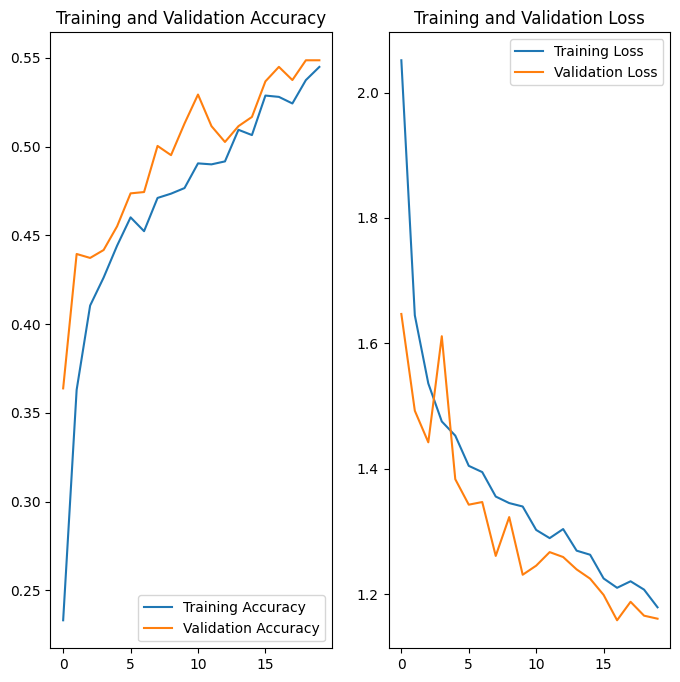

In [40]:
# Adding the data_augmentation layer back and removing batch normalization layers
model_with_aug_drop_3 = tf.keras.Sequential([
  InputLayer(input_shape=(img_height, img_width, 3)),
  data_augmentation,
  Rescaling(1./255),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(128, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.5),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

# Model compilation
model_with_aug_drop_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Training the model for 20 epochs
epochs = 20
history = model_with_aug_drop_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

show_history(history)

#### Observations
- The data augmentation layer helps in stabilizing the model.
- There doesn't seem to be overfitting as the gap between training and validation accuracies is not large.
- Increasing the number of epochs might be helpful for this model as the overfitting doesn't seem to be there.

Epoch 1/20
169/169 [==============================] - 54s 296ms/step - loss: 2.6237 - accuracy: 0.2845 - val_loss: 2.2129 - val_accuracy: 0.1507
Epoch 2/20
169/169 [==============================] - 53s 306ms/step - loss: 1.8813 - accuracy: 0.3064 - val_loss: 2.1049 - val_accuracy: 0.1930
Epoch 3/20
169/169 [==============================] - 41s 234ms/step - loss: 1.8096 - accuracy: 0.3212 - val_loss: 1.8438 - val_accuracy: 0.3014
Epoch 4/20
169/169 [==============================] - 41s 235ms/step - loss: 1.7536 - accuracy: 0.3492 - val_loss: 1.9951 - val_accuracy: 0.2702
Epoch 5/20
169/169 [==============================] - 41s 235ms/step - loss: 1.6807 - accuracy: 0.3644 - val_loss: 1.7128 - val_accuracy: 0.3801
Epoch 6/20
169/169 [==============================] - 40s 232ms/step - loss: 1.6123 - accuracy: 0.3889 - val_loss: 1.7631 - val_accuracy: 0.3200
Epoch 7/20
169/169 [==============================] - 43s 249ms/step - loss: 1.5468 - accuracy: 0.4078 - val_loss: 1.6129 - val_ac

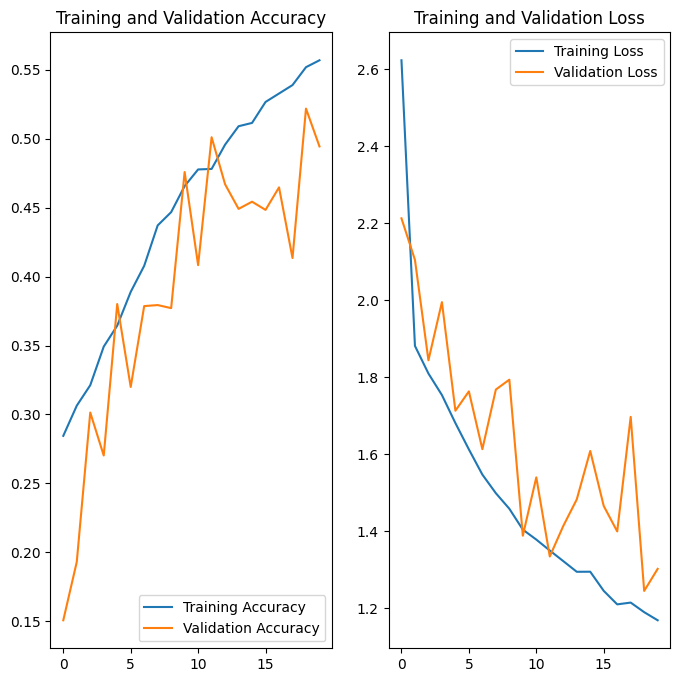

In [42]:
# Adding the data_augmentation layer back along with batch normalization layers
model_with_aug_drop_4 = tf.keras.Sequential([
  InputLayer(input_shape=(img_height, img_width, 3)),
  data_augmentation,
  Rescaling(1./255),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  BatchNormalization(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  BatchNormalization(),
  Conv2D(128, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.5),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

# Model compilation
model_with_aug_drop_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Training the model for 20 epochs
epochs = 20
history = model_with_aug_drop_4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

show_history(history)

#### Observations
- Definitely not an improvement over the last model.
- With batch normalization, the model might have become faster, but the difference in accuracies jump with increasing epochs.

Epoch 1/30
169/169 [==============================] - 43s 238ms/step - loss: 2.1890 - accuracy: 0.1398 - val_loss: 2.1859 - val_accuracy: 0.1403
Epoch 2/30
169/169 [==============================] - 40s 232ms/step - loss: 2.1765 - accuracy: 0.1537 - val_loss: 2.1765 - val_accuracy: 0.1359
Epoch 3/30
169/169 [==============================] - 42s 242ms/step - loss: 2.1531 - accuracy: 0.1808 - val_loss: 2.1703 - val_accuracy: 0.1626
Epoch 4/30
169/169 [==============================] - 40s 233ms/step - loss: 2.1062 - accuracy: 0.2044 - val_loss: 1.9908 - val_accuracy: 0.2955
Epoch 5/30
169/169 [==============================] - 40s 233ms/step - loss: 2.0579 - accuracy: 0.2105 - val_loss: 1.8769 - val_accuracy: 0.2955
Epoch 6/30
169/169 [==============================] - 39s 223ms/step - loss: 1.9983 - accuracy: 0.2309 - val_loss: 1.8640 - val_accuracy: 0.3311
Epoch 7/30
169/169 [==============================] - 43s 246ms/step - loss: 1.9153 - accuracy: 0.2695 - val_loss: 1.7719 - val_ac

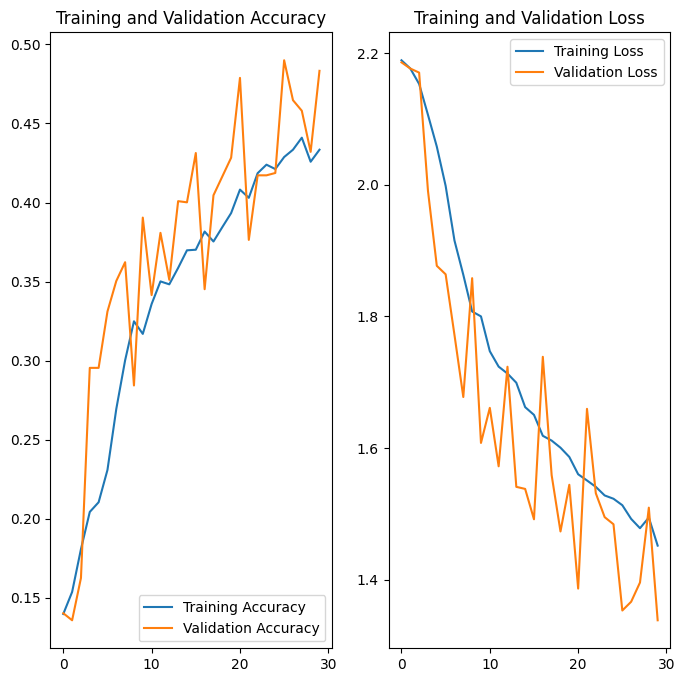

In [ ]:
# Adding the data_augmentation layer back along with batch normalization layers and increasing the number of epochs
model_with_aug_drop_4a = tf.keras.Sequential([
  InputLayer(input_shape=(img_height, img_width, 3)),
  data_augmentation,
  Rescaling(1./255),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  BatchNormalization(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  BatchNormalization(),
  Conv2D(128, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.5),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

# Model compilation
model_with_aug_drop_4a.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Training the model for 30 epochs
epochs = 30
history = model_with_aug_drop_4a.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

show_history(history)

Epoch 1/50
169/169 [==============================] - 42s 226ms/step - loss: 1.8683 - accuracy: 0.2928 - val_loss: 1.5789 - val_accuracy: 0.4105
Epoch 2/50
169/169 [==============================] - 41s 234ms/step - loss: 1.5564 - accuracy: 0.3980 - val_loss: 1.4784 - val_accuracy: 0.4254
Epoch 3/50
169/169 [==============================] - 39s 218ms/step - loss: 1.4840 - accuracy: 0.4258 - val_loss: 1.5443 - val_accuracy: 0.4291
Epoch 4/50
169/169 [==============================] - 39s 223ms/step - loss: 1.4664 - accuracy: 0.4388 - val_loss: 1.4131 - val_accuracy: 0.4595
Epoch 5/50
169/169 [==============================] - 39s 226ms/step - loss: 1.4123 - accuracy: 0.4501 - val_loss: 1.3025 - val_accuracy: 0.5056
Epoch 6/50
169/169 [==============================] - 42s 241ms/step - loss: 1.3804 - accuracy: 0.4662 - val_loss: 1.3388 - val_accuracy: 0.4878
Epoch 7/50
169/169 [==============================] - 45s 258ms/step - loss: 1.3589 - accuracy: 0.4701 - val_loss: 1.4394 - val_ac

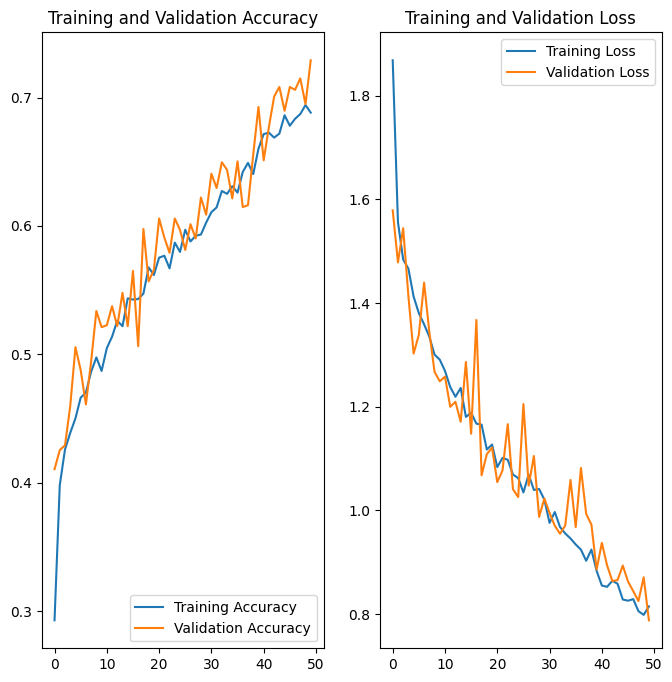

In [44]:
# Training the model with data_augmentation and dropout layers again, but with larger number of epochs
model_with_aug_drop_3a = tf.keras.Sequential([
  InputLayer(input_shape=(img_height, img_width, 3)),
  data_augmentation,
  Rescaling(1./255),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(128, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.5),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

# Model compilation
model_with_aug_drop_3a.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Training the model for 50 epochs
epochs = 50
history = model_with_aug_drop_3a.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

show_history(history)

#### Observations
- This seems to be the most stable model with no overfitting.
- Since overfitting is absent, we can keep on increasing the number of epochs for better accuracy.
- Large number of epochs does increase the time it takes to train the model.

### Emulating AlexNet model for a large number of epochs

Epoch 1/50
169/169 [==============================] - 44s 239ms/step - loss: 2.1845 - accuracy: 0.1404 - val_loss: 2.1818 - val_accuracy: 0.1403
Epoch 2/50
169/169 [==============================] - 52s 302ms/step - loss: 2.1647 - accuracy: 0.1664 - val_loss: 2.1357 - val_accuracy: 0.2034
Epoch 3/50
169/169 [==============================] - 44s 257ms/step - loss: 2.1293 - accuracy: 0.1947 - val_loss: 2.1048 - val_accuracy: 0.1522
Epoch 4/50
169/169 [==============================] - 40s 230ms/step - loss: 2.0729 - accuracy: 0.2129 - val_loss: 2.0876 - val_accuracy: 0.2175
Epoch 5/50
169/169 [==============================] - 39s 227ms/step - loss: 2.0185 - accuracy: 0.2231 - val_loss: 2.1382 - val_accuracy: 0.1797
Epoch 6/50
169/169 [==============================] - 40s 232ms/step - loss: 1.9580 - accuracy: 0.2485 - val_loss: 2.1117 - val_accuracy: 0.1826
Epoch 7/50
169/169 [==============================] - 40s 228ms/step - loss: 1.9551 - accuracy: 0.2474 - val_loss: 1.7811 - val_ac

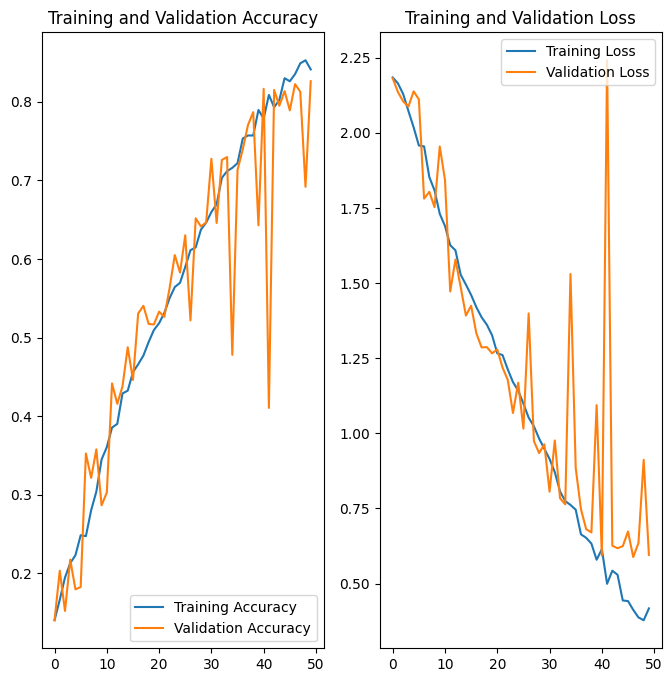

In [43]:
num_classes = 9
epochs = 50

# Building a model similar to AlexNet without data_augmentation layer and training it for 50 epochs
alexnet_model_without_aug = tf.keras.Sequential([
  InputLayer(input_shape=(img_height, img_width, 3)),
  Rescaling(1./255),
  Conv2D(32, 3, padding='same', activation='relu'),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.25),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(0.5),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

alexnet_model_without_aug.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = alexnet_model_without_aug.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

show_history(history)

#### Observations
- The model similar to AlexNet seems to be simple but effective with high accuracy.
- Since the gap in the training and validation accuracies is low, there doesn't seem to be overfitting in the model.